In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os
import time

In [16]:
# Function to evaluate the entropy of a vector
# INPUTS
# - v: vector that contains in each cell the value of a byte (so from 0 to 255)
# - num: number of cells of the vector we want to consider in the analysis (from the first element)
# OUTPUT: entropy value
def entropy(v, num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h + (freq[i]/num) * np.log2(freq[i]/num)
    h = -h
    return h

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed

def entropy_analysis(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file, 8*i)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,length-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, start, offset):
    vec = np.zeros(offset)
    for i in range(offset):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

def accuracies(threshold, area, y):
    accur, err = 0.0, 0.0
    if y==False and area > threshold:
        accur = 1.0
    # True positives
    if y==True and area <= threshold:
        accur = 1.0
    # False negatives
    if y==True and area > threshold:
        err = 1.0
    # False positives
    if y==False and area <= threshold:
        err = 1.0
    return accur, err

def trapezoidal_rule(ideal_file, file_vector, best_hl):
    h_ideal = entropy_analysis(ideal_file, best_hl)
    h = entropy_analysis(file_vector, best_hl)
    return diff_area(h_ideal,h)

def get_areas(file, offset, best_hl, num_fragms):
    begin = start = 0
    i = 1
    bound = len(file) // num_fragms
    if len(file) < num_fragms * offset:
        bound = len(file) // (len(file) // offset)
    areas = []
    while i <= num_fragms and len(file) >= i*offset and start < len(file) - offset:
        file_vector = file_to_vector(file, start, offset)
        areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
        begin = start + offset
        if begin >= len(file) - offset:
            begin = i * bound
        if i == num_fragms and begin < len(file) - offset -1:
            start = randint(begin, len(file) - offset -1)
        else:
            start = randint(begin, (i+1) * bound - offset)
        i+=1
    return areas

def get_best_area(distance, areas):
    best_area = 0
    i=2
    mean_random_area = areas[1]
    while i < len(areas):
        mean_random_area = mean_random_area + areas[i]
        i+=1
    mean_random_area = mean_random_area / (i-1)
    if areas[0] - distance < mean_random_area:
        best_area = areas[0]
    else:
        best_area = min(areas[0], mean_random_area)
    return best_area

def update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area):
    # Iterate over different threshold values
    if paths[j][20:25] == "EXTRA":
        results = accuracies(best_thresh, best_area, True)
        acc[j] = np.add(acc[j], results[0], dtype=float)
        true_positives[j] = np.add(true_positives[j], results[0], dtype=float)
        false_negatives[j] = np.add(false_negatives[j], results[1], dtype=float)
    else:
        results = accuracies(best_thresh, best_area, False)
        acc[j] = np.add(acc[j], results[0], dtype=float)
        true_negatives[j] = np.add(true_negatives[j], results[0], dtype=float)
        false_positives[j] = np.add(false_positives[j], results[1], dtype=float)

## BEST MODEL FOR DAA, MIXED DATASET

In [41]:
thresholds = np.arange(8,80,2)
offset = 256
acc_des=np.load('../results/acc_DAA_mix.npy')
acc_des = acc_des.reshape(len(thresholds), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_hl = thresholds[ind[0]], 8*(ind[1]+1)

In [42]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [5]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*offset:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            area = trapezoidal_rule(ideal_file, file_vector, best_hl)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, area)
            files_analyzed[j] += 1
        f.close()

acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [6]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_DAA_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_DAA_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_DAA_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_DAA_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_DAA_mix.npy", false_positives, fix_imports=False)

In [43]:
# deserialize the tensor from the file .npy
acc_DAA_mix=np.load('../results/paths_acc_DAA_mix.npy')

TN_DAA_mix=np.load('../results/paths_TN_DAA_mix.npy')

TP_DAA_mix=np.load('../results/paths_TP_DAA_mix.npy')

FN_DAA_mix=np.load('../results/paths_FN_DAA_mix.npy')

FP_DAA_mix=np.load('../results/paths_FP_DAA_mix.npy')

In [44]:
print("Best parameters: threshold %2d, header length %2d" % (best_thresh, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_DAA_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_DAA_mix)
FP_mean = np.mean(FP_DAA_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_DAA_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_DAA_org = acc_DAA_mix[27:]
TN_DAA_org = TN_DAA_mix[27:]
TP_DAA_org = TP_DAA_mix[27:]
FN_DAA_org = FN_DAA_mix[27:]
FP_DAA_org = FP_DAA_mix[27:]

accur = np.mean(acc_DAA_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_DAA_org)
FP_mean = np.mean(FP_DAA_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_DAA_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 12, header length 56
STATISTICS ON MIXED DATASET
Accuracy: 48.85
Precision: 87.78
Recall: 23.75
F1: 37.39
STATISTICS ON ORIGINAL DATASET
Accuracy: 94.34
Precision: 87.78
Recall: 95.00
F1: 91.25


## BEST MODEL FOR 2F, MIXED DATASET

In [45]:
thresholds = np.arange(2,35,1)
distances = np.arange(24,51,3)
offset = 256
acc_des=np.load('../results/acc_2F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [46]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [13]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 2*offset:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            # Second fragment
            start = randint(offset, len(file) - offset)                
            file_vector = file_to_vector(file, start, offset)
            areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            
            if areas[0] - best_dist < areas[1]:
                best_area = areas[0]
            else:
                best_area = min(areas[0], areas[1])

            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()

acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [14]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_2F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_2F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_2F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_2F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_2F_mix.npy", false_positives, fix_imports=False)

In [47]:
# deserialize the tensor from the file .npy
acc_2F_mix=np.load('../results/paths_acc_2F_mix.npy')

TN_2F_mix=np.load('../results/paths_TN_2F_mix.npy')

TP_2F_mix=np.load('../results/paths_TP_2F_mix.npy')

FN_2F_mix=np.load('../results/paths_FN_2F_mix.npy')

FP_2F_mix=np.load('../results/paths_FP_2F_mix.npy')

#### STATISTICS

In [48]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_2F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_2F_mix)
FP_mean = np.mean(FP_2F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_2F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_2F_org = acc_2F_mix[27:]
TN_2F_org = TN_2F_mix[27:]
TP_2F_org = TP_2F_mix[27:]
FN_2F_org = FN_2F_mix[27:]
FP_2F_org = FP_2F_mix[27:]

accur = np.mean(acc_2F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_2F_org)
FP_mean = np.mean(FP_2F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_2F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold  8, distance 39, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 92.55
Precision: 94.12
Recall: 94.31
F1: 94.21
STATISTICS ON ORIGINAL DATASET
Accuracy: 89.85
Precision: 79.42
Recall: 90.89
F1: 84.77


## BEST MODEL FOR SW-2F, MIXED DATASET

In [49]:
thresholds = np.arange(2,35,1)
distances = np.arange(24,51,3)
offset = 256
acc_des=np.load('../results/acc_SW2F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [50]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [20]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= 3*offset:
            best_area = 0
            areas = []
            file_vector = file_to_vector(file, 0, best_hl)
            areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            # Second fragment
            start = randint(offset, len(file) - (offset+64*3))
            vector = file_to_vector(file, start, offset+64*3)
            for sw in range(0,4):
                file_vector = vector[0+64*sw:256+64*sw]
                areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
            
            best_area = get_best_area(best_dist, offset, areas, 5, file)

            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()

acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [21]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_SW2F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_SW2F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_SW2F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_SW2F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_SW2F_mix.npy", false_positives, fix_imports=False)

In [51]:
# deserialize the tensor from the file .npy
acc_SW2F_mix=np.load('../results/paths_acc_SW2F_mix.npy')

TN_SW2F_mix=np.load('../results/paths_TN_SW2F_mix.npy')

TP_SW2F_mix=np.load('../results/paths_TP_SW2F_mix.npy')

FN_SW2F_mix=np.load('../results/paths_FN_SW2F_mix.npy')

FP_SW2F_mix=np.load('../results/paths_FP_SW2F_mix.npy')

#### STATISTICS

In [52]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_SW2F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_SW2F_mix)
FP_mean = np.mean(FP_SW2F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_SW2F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_SW2F_org = acc_SW2F_mix[27:]
TN_SW2F_org = TN_SW2F_mix[27:]
TP_SW2F_org = TP_SW2F_mix[27:]
FN_SW2F_org = FN_SW2F_mix[27:]
FP_SW2F_org = FP_SW2F_mix[27:]

accur = np.mean(acc_SW2F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_SW2F_org)
FP_mean = np.mean(FP_SW2F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_SW2F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold  9, distance 39, header length 48
STATISTICS ON MIXED DATASET
Accuracy: 92.14
Precision: 92.61
Recall: 95.44
F1: 94.01
STATISTICS ON ORIGINAL DATASET
Accuracy: 89.41
Precision: 76.03
Recall: 96.56
F1: 85.07


## BEST MODEL FOR 3F, MIXED DATASET

In [22]:
thresholds = np.arange(2,35,1)
distances = np.arange(48,80,2)
offset = 256
acc_des=np.load('../results/acc_3F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [23]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])
num_fragms = 3

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [24]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        areas = []
        if len(file) >= 2*offset:
            areas = get_areas(file, offset, best_hl, num_fragms)
            best_area = get_best_area(best_dist, areas)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()
acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [25]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_3F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_3F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_3F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_3F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_3F_mix.npy", false_positives, fix_imports=False)

In [26]:
# deserialize the tensor from the file .npy
acc_3F_mix=np.load('../results/paths_acc_3F_mix.npy')

TN_3F_mix=np.load('../results/paths_TN_3F_mix.npy')

TP_3F_mix=np.load('../results/paths_TP_3F_mix.npy')

FN_3F_mix=np.load('../results/paths_FN_3F_mix.npy')

FP_3F_mix=np.load('../results/paths_FP_3F_mix.npy')

#### STATISTICS

In [27]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_3F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_3F_mix)
FP_mean = np.mean(FP_3F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_3F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_3F_org = acc_3F_mix[27:]
TN_3F_org = TN_3F_mix[27:]
TP_3F_org = TP_3F_mix[27:]
FN_3F_org = FN_3F_mix[27:]
FP_3F_org = FP_3F_mix[27:]

accur = np.mean(acc_3F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_3F_org)
FP_mean = np.mean(FP_3F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_3F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 15, distance 56, header length 56
STATISTICS ON MIXED DATASET
Accuracy: 92.35
Precision: 93.72
Recall: 94.44
F1: 94.08
STATISTICS ON ORIGINAL DATASET
Accuracy: 90.95
Precision: 79.16
Recall: 96.22
F1: 86.86


## BEST MODEL FOR 4F, MIXED DATASET

In [34]:
thresholds = np.arange(2,35,1)
distances = np.arange(48,80,2)
offset = 256
acc_des=np.load('../results/acc_4F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [35]:
ideal_file = np.zeros(best_hl)
for i in range(best_hl):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('../paths/mixed_dataset.txt', 'r')
paths = f.readlines()
f.close()
files_analyzed = np.zeros([len(paths)])
num_fragms = 4

acc = np.zeros([len(paths)], dtype = float)
true_positives = np.zeros([len(paths)], dtype = float)
false_negatives = np.zeros([len(paths)], dtype = float)
true_negatives = np.zeros([len(paths)], dtype = float)
false_positives = np.zeros([len(paths)], dtype = float)

In [36]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        areas = []
        if len(file) >= 2*offset:
            areas = get_areas(file, offset, best_hl, num_fragms)
            best_area = get_best_area(best_dist, areas)
            update_statistics(best_thresh, paths, j, acc, false_positives, false_negatives, true_positives, true_negatives, best_area)
            files_analyzed[j] += 1
        f.close()
acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))

Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/BadRabbit-tiny-repeat-ciphertext
Start analysizng the directory ../NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-header
Start analysizng the directory ..

In [37]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code

np.save("../results/paths_acc_4F_mix.npy", acc, fix_imports=False)

np.save("../results/paths_TN_4F_mix.npy", true_negatives, fix_imports=False)

np.save("../results/paths_TP_4F_mix.npy", true_positives, fix_imports=False)

np.save("../results/paths_FN_4F_mix.npy", false_negatives, fix_imports=False)

np.save("../results/paths_FP_4F_mix.npy", false_positives, fix_imports=False)

In [38]:
# deserialize the tensor from the file .npy
acc_4F_mix=np.load('../results/paths_acc_4F_mix.npy')

TN_4F_mix=np.load('../results/paths_TN_4F_mix.npy')

TP_4F_mix=np.load('../results/paths_TP_4F_mix.npy')

FN_4F_mix=np.load('../results/paths_FN_4F_mix.npy')

FP_4F_mix=np.load('../results/paths_FP_4F_mix.npy')

 #### STATISTICS

In [39]:
print("Best parameters: threshold %2d, distance %2d, header length %2d" % (best_thresh, best_dist, best_hl))
print("STATISTICS ON MIXED DATASET")

accur = np.mean(acc_4F_mix)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_4F_mix)
FP_mean = np.mean(FP_4F_mix)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_4F_mix)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

print("STATISTICS ON ORIGINAL DATASET")

acc_4F_org = acc_4F_mix[27:]
TN_4F_org = TP_4F_mix[27:]
TP_4F_org = TN_4F_mix[27:]
FN_4F_org = FN_4F_mix[27:]
FP_4F_org = FP_4F_mix[27:]

accur = np.mean(acc_4F_org)
print("Accuracy: %3.2f" % (accur))

TP_mean = np.mean(TP_4F_org)
FP_mean = np.mean(FP_4F_org)
prec = TP_mean / (TP_mean + FP_mean) * 100
print("Precision: %3.2f" % (prec))

FN_mean = np.mean(FN_4F_org)
rec = TP_mean / (TP_mean + FN_mean) * 100
print("Recall: %3.2f" % (rec))

rec = 2 * (prec * rec) / (prec + rec)
print("F1: %3.2f" % (rec))

Best parameters: threshold 14, distance 48, header length 56
STATISTICS ON MIXED DATASET
Accuracy: 90.18
Precision: 90.39
Recall: 94.86
F1: 92.57
STATISTICS ON ORIGINAL DATASET
Accuracy: 86.34
Precision: 81.72
Recall: 98.13
F1: 89.18


## PLOTS OF THE ACCURACIES FOR EACH FILE TYPE

In [53]:
f = open('../paths/mixed_dataset.txt', 'r')
# asse x i modelli, asse y le accuracy, colorati i vari tipi di files
paths = f.readlines()
f.close()
short_paths = paths
for i in range(len(paths)):
    p = paths[i].split("/")
    short_paths[i] = p[-1][:-1]
    short_paths[i] = short_paths[i].replace('-tiny','')
    short_paths[i] = short_paths[i].replace('RANSOMWARE-','')
    s=short_paths[i].split("-")
    if len(s) > 1:
        short_paths[i] = short_paths[i].replace(s[1],s[1][0])
    if len(s) > 2:
        short_paths[i] = short_paths[i].replace(s[2],s[2][0])
    if len(s) > 3:
        short_paths[i] = short_paths[i].replace(s[3],s[3][0])
    s=short_paths[i].split("-")
    if len(s[0]) > 4:
        short_paths[i] = short_paths[i].replace(s[0], s[0][0]+ s[0][int(len(s[0])/2)] +s[0][-1])
print("The following will be the abbreviate names for the paths:")
print(short_paths)

The following will be the abbreviate names for the paths:
['MAZE-r-c', 'DRA-r-c', 'NAR-r-c', 'NEA-r-c', 'PBS-r-c', 'RYUK-r-c', 'SOI-r-c', 'Way-r-c', 'Bat-r-c', 'MAZE-l-e-h', 'DRA-l-e-h', 'NAR-l-e-h', 'NEA-l-e-h', 'PBS-l-e-h', 'RYUK-l-e-h', 'SOI-l-e-h', 'Way-l-e-h', 'Bat-l-e-h', 'MAZE-c-s', 'DRA-c-s', 'NAR-c-s', 'NEA-c-s', 'PBS-c-s', 'RYUK-c-s', 'SOI-c-s', 'Way-c-s', 'Bat-c-s', 'MAZE', 'DRA', 'NAR', 'NEA', 'PBS', 'RYUK', 'SOI', 'Bat', 'Way', 'JPG-f-w', 'PDF', 'PPTX', 'XLS', 'XLSX', '7ZIP-B', '7ZIP-E', '7ZIP-H-C', 'CSS', 'DLL', 'GIF', 'MKV', 'MP3', 'MP4', 'PNG-c', 'RAR', 'TAR', 'XML', 'DOCX', 'DOC']


#### RANDOMLY PLOT THE ACCURACIES FOR 23 DIFFERENT FILE TYPES

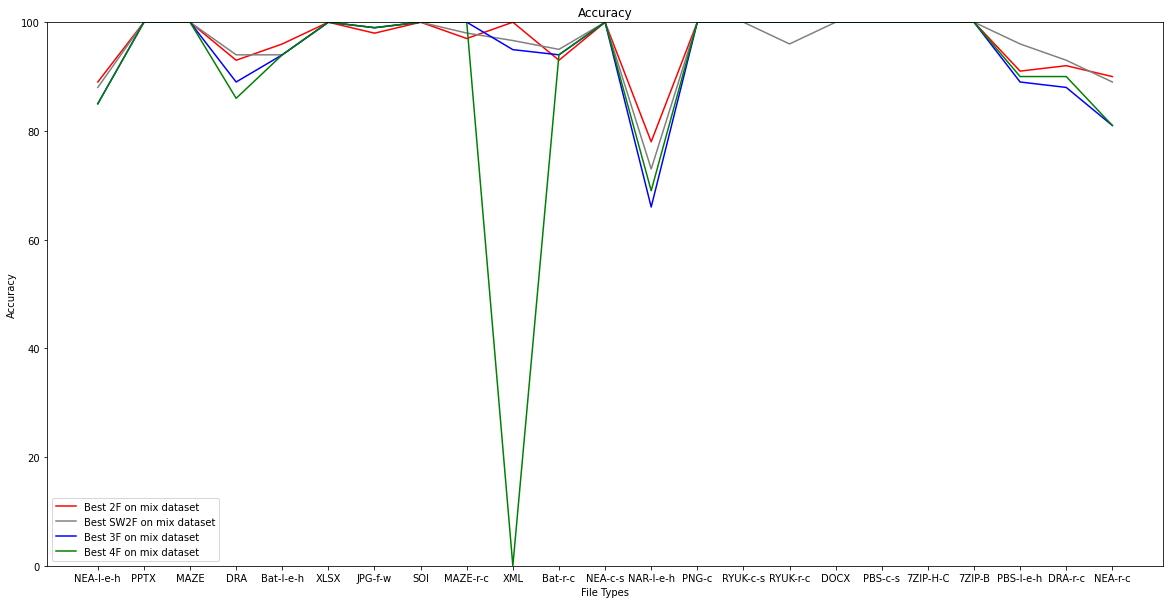

In [54]:
plt.figure(figsize=(20,10))
plt.title("Accuracy")
plt.xlabel("File Types")
plt.ylabel("Accuracy")

num_paths = 23
new_acc_2F_mix=np.zeros(num_paths, dtype=float)
new_acc_SW2F_mix=np.zeros(num_paths, dtype=float)
new_acc_3F_mix=np.zeros(num_paths, dtype=float)
new_acc_4F_mix=np.zeros(num_paths, dtype=float)
new_paths=[]
indexes=np.full(num_paths, 56, dtype = int)

for i in range(0,num_paths):
    r = randint(0, len(short_paths)-1)
    while r in indexes:
        r = randint(0, len(short_paths)-1)
    indexes[i] = r
    new_acc_2F_mix[i] = acc_2F_mix[r]
    new_acc_SW2F_mix[i] = acc_SW2F_mix[r]
    new_acc_3F_mix[i] = acc_3F_mix[r]
    new_acc_4F_mix[i] = acc_4F_mix[r]
    new_paths.append(short_paths[r])


plt.plot(new_paths, new_acc_2F_mix, color="red", label="Best 2F on mix dataset")
plt.plot(new_paths, new_acc_SW2F_mix, color="gray", label="Best SW2F on mix dataset")
plt.plot(new_paths, new_acc_3F_mix, color="blue", label="Best 3F on mix dataset")
plt.plot(new_paths, new_acc_4F_mix, color="green", label="Best 4F on mix dataset")
plt.ylim([0, 100])
plt.legend()
plt.show()

#### PLOT THE ACCURACIES FOR THE FIRST 28 FILE TYPES

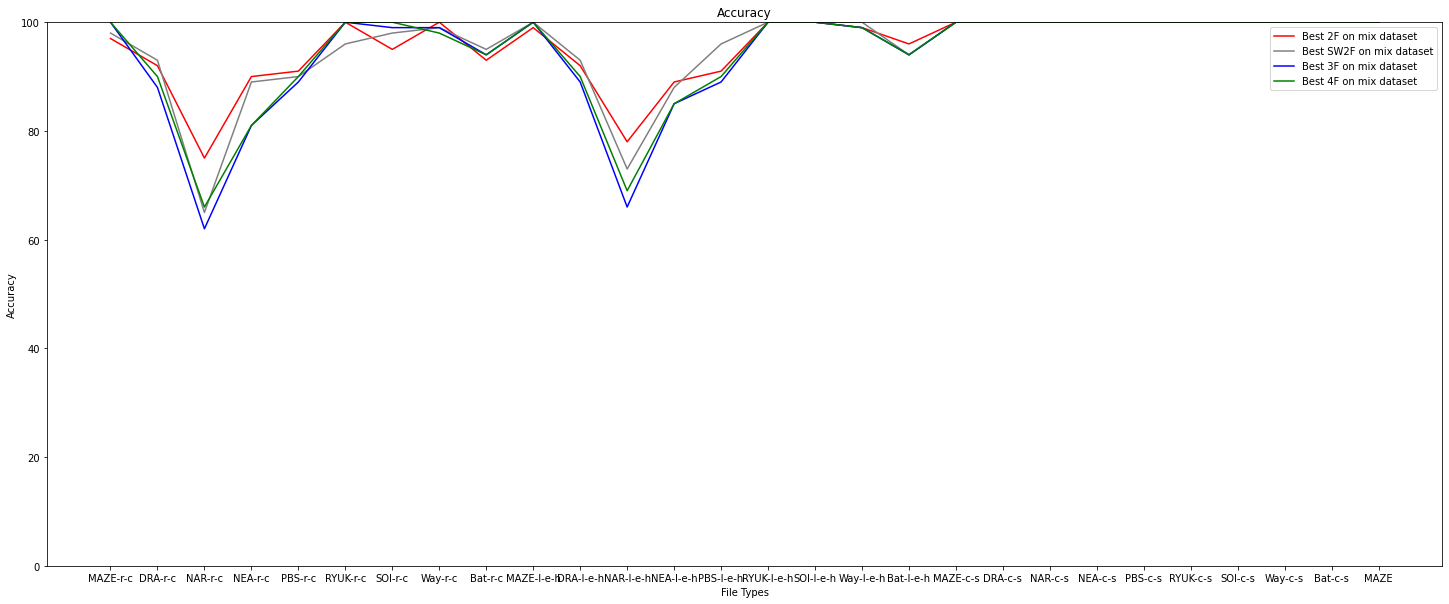

In [55]:
plt.figure(figsize=(25,10))
plt.title("Accuracy")
plt.xlabel("File Types")
plt.ylabel("Accuracy")

plt.plot(short_paths[:28], acc_2F_mix[:28], color="red", label="Best 2F on mix dataset")
plt.plot(short_paths[:28], acc_SW2F_mix[:28], color="grey", label="Best SW2F on mix dataset")
plt.plot(short_paths[:28], acc_3F_mix[:28], color="blue", label="Best 3F on mix dataset")
plt.plot(short_paths[:28], acc_4F_mix[:28], color="green", label="Best 4F on mix dataset")
plt.ylim([0, 100])
plt.legend()
plt.show()

#### PLOT THE ACCURACIES FOR THE REMAINING 28 FILE TYPES

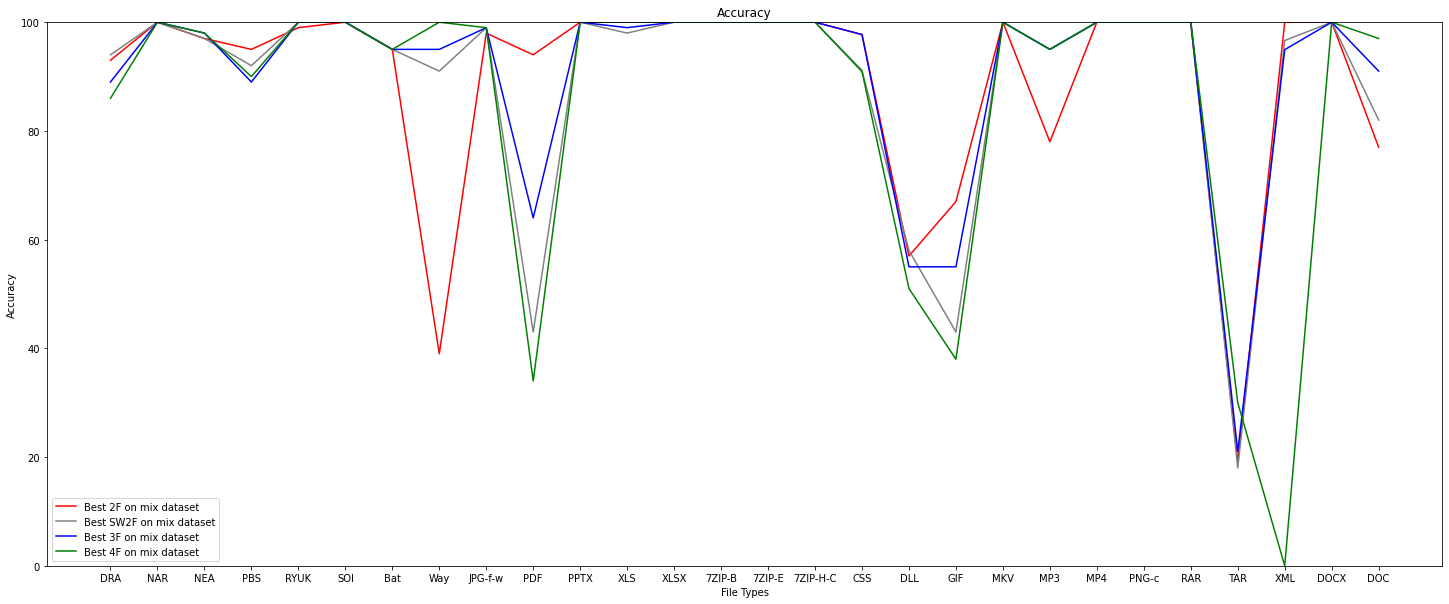

In [56]:
plt.figure(figsize=(25,10))
plt.title("Accuracy")
plt.xlabel("File Types")
plt.ylabel("Accuracy")

plt.plot(short_paths[28:], acc_2F_mix[28:], color="red", label="Best 2F on mix dataset")
plt.plot(short_paths[28:], acc_SW2F_mix[28:], color="grey", label="Best SW2F on mix dataset")
plt.plot(short_paths[28:], acc_3F_mix[28:], color="blue", label="Best 3F on mix dataset")
plt.plot(short_paths[28:], acc_4F_mix[28:], color="green", label="Best 4F on mix dataset")
plt.ylim([0, 100])
plt.legend()
plt.show()

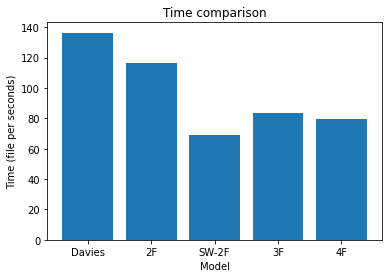

In [57]:
model = ["Davies", "2F", "SW-2F", "3F", "4F"]
time = [41/5590,48/5590,81/5571,67/5590,70/5590]
time1= [5590/41,5590/48,5571/81,5590/67,5590/70]
x_pos = np.arange(len(model))

plt.bar(x_pos, time1, align='center')
plt.xticks(x_pos, model)
plt.ylabel('Time (file per seconds)')
plt.xlabel('Model')
plt.title('Time comparison')
plt.show()

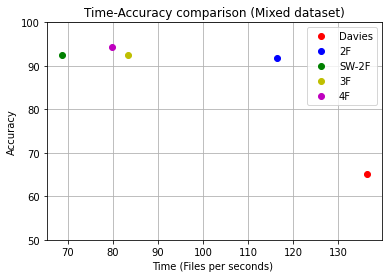

In [58]:
time = [41/5590,48/5590,81/5571,67/5590,70/5590]
time1= [5590/41,5590/48,5571/81,5590/67,5590/70]
acc_mix = [65.05,91.91,92.58,92.58,94.40]

plt.plot(time1[0], acc_mix[0],'ro', label="Davies")
plt.plot(time1[1], acc_mix[1],'bo', label="2F")
plt.plot(time1[2], acc_mix[2],'go', label="SW-2F")
plt.plot(time1[3], acc_mix[3],'yo', label="3F")
plt.plot(time1[4], acc_mix[4],'mo', label="4F")
plt.legend()
plt.grid()
plt.ylim([50 ,100])
plt.ylabel('Accuracy')
plt.xlabel('Time (Files per seconds) ')
plt.title('Time-Accuracy comparison (Mixed dataset)')
plt.show()

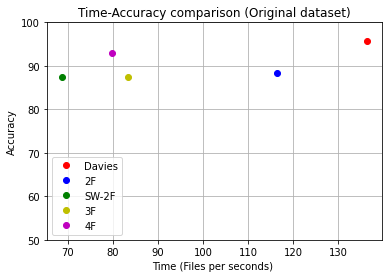

In [59]:
time = [41/5590,48/5590,81/5571,67/5590,70/5590]
time1= [5590/41,5590/48,5571/81,5590/67,5590/70]
acc_org = [95.79,88.28,87.40,87.37,92.90]

plt.plot(time1[0], acc_org[0],'ro', label="Davies")
plt.plot(time1[1], acc_org[1],'bo', label="2F")
plt.plot(time1[2], acc_org[2],'go', label="SW-2F")
plt.plot(time1[3], acc_org[3],'yo', label="3F")
plt.plot(time1[4], acc_org[4],'mo', label="4F")
plt.legend()
plt.grid()
plt.ylim([50 ,100])
plt.ylabel('Accuracy')
plt.xlabel('Time (Files per seconds) ')
plt.title('Time-Accuracy comparison (Original dataset)')
plt.show()